# Setup

In [167]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
import keras
import tensorflow as tf

Load our data

In [3]:
# SPX historical market data from Yahoo Finance
# Source:  https://finance.yahoo.com/quote/%5ESPX/history?period1=-1325635200&period2=1710633600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
SPX_historical = pd.read_csv('SPX_historical.csv')
SPX_historical.rename({"Adj Close" : "AdjClose"}, axis = 1, inplace = True)
SPX_historical.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


# Initial EDA

In [4]:
print("Object type: ", type(SPX_historical))
print("Dimensions: ", SPX_historical.shape)
print("Date range: ", SPX_historical["Date"].min(), "to", SPX_historical["Date"].max())
print("Index values range: ", SPX_historical["Low"].min(), "-", SPX_historical["High"].max())
print("Missing values: ", SPX_historical.isna().sum().sum())

Object type:  <class 'pandas.core.frame.DataFrame'>
Dimensions:  (24167, 7)
Date range:  1927-12-30 to 2024-03-15
Index values range:  4.4 - 5189.259766
Missing values:  0


We have nearly a century of data, however, the extreme values range, and changes in historic changes in economic structures and measurement methods leads me to believe we should investigate this data further. It also appears much of the data for the earliest dates contains the same values for Open, High, Low, and Close. While it might be possible to observe some kind of patterns in day-to-day change, I fear this total colinearity will weaken any model that is looking at *all* of these variables.

In [5]:
Same = SPX_historical.loc[SPX_historical["Open"] != SPX_historical["Close"]]
Same.head()

,Date,Open,High,Low,Close,AdjClose,Volume
8509,1962-01-02,0.0,71.959999,70.709999,70.959999,70.959999,3120000
8510,1962-01-03,0.0,71.480003,70.379997,71.129997,71.129997,3590000
8511,1962-01-04,0.0,71.620003,70.449997,70.639999,70.639999,4450000
8512,1962-01-05,0.0,70.839996,69.349998,69.660004,69.660004,4630000
8513,1962-01-08,0.0,69.839996,68.169998,69.120003,69.120003,4620000


Further investigation reveals that different High, Low, Open, and Close values were not recorded for years prior to 1961. I also want to investigate 'Open' values.

In [6]:
OpenZero = SPX_historical.loc[SPX_historical["Open"] == 0.0]
OpenZero.head()

,Date,Open,High,Low,Close,AdjClose,Volume
8509,1962-01-02,0.0,71.959999,70.709999,70.959999,70.959999,3120000
8510,1962-01-03,0.0,71.480003,70.379997,71.129997,71.129997,3590000
8511,1962-01-04,0.0,71.620003,70.449997,70.639999,70.639999,4450000
8512,1962-01-05,0.0,70.839996,69.349998,69.660004,69.660004,4630000
8513,1962-01-08,0.0,69.839996,68.169998,69.120003,69.120003,4620000


"Open" values are consistently zero from 1962 through 1982. Given all the discrepancies above *and* the beginning of financialization in the 1980s, which contributed to significant changes in the ways the market might behave, I first opted to remove all rows prior to 1983. After further exploration, I discovered that this may still be too far back for creating a model for predicting modern stock price movement. so, I also remove all rows prior to May 2004. This date also brings my model in line with the dates used for my partner's model.

In [7]:
SPX_historical = SPX_historical.iloc[19165:].reset_index(drop=True)
SPX_historical.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,2004-05-03,1107.300049,1118.719971,1107.300049,1117.489990,1117.489990,1571600000
1,2004-05-04,1117.489990,1127.739990,1112.890015,1119.550049,1119.550049,1662100000
2,2004-05-05,1119.550049,1125.069946,1117.900024,1121.530029,1121.530029,1469000000
3,2004-05-06,1121.530029,1121.530029,1106.300049,1113.989990,1113.989990,1509300000
4,2004-05-07,1113.989990,1117.300049,1098.630005,1098.699951,1098.699951,1653600000


Next, I generate a plot to visualize Adjusted Close data over the remaining dataset.

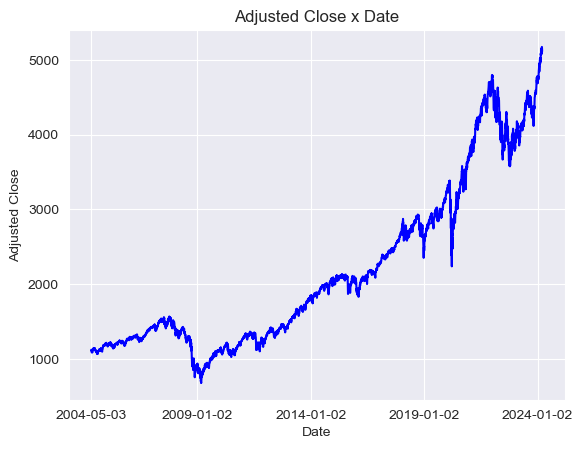

In [8]:
X = SPX_historical["Date"]
Y = SPX_historical["AdjClose"]
plt.figure()
plt.plot(X, Y, marker='', color='blue')
plt.title('Adjusted Close x Date')
plt.xticks([0,1176,2434,3692,4950])
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.grid(True)
plt.show()

# Feature creation & selection

I start by creating a day average variable. This information is sometimes used for market prediction, and I aim to experiment incorporating it into my model.

In [9]:
SPX_historical.loc[:,"DayAvg"] = (SPX_historical["High"] + SPX_historical["Low"])/2
SPX_historical["DayAvg"].head()

0    1113.010010
1    1120.315002
2    1121.484985
3    1113.915039
4    1107.965027
Name: DayAvg, dtype: float64

Here, I create lag-terms for all of my features.

In [10]:
# "Open" lags
SPX_historical["OpenLag1"] = SPX_historical["Open"].shift(1)
SPX_historical["OpenLag2"] = SPX_historical["Open"].shift(2)
SPX_historical["OpenLag3"] = SPX_historical["Open"].shift(3)
SPX_historical["OpenLag4"] = SPX_historical["Open"].shift(4)
SPX_historical["OpenLag5"] = SPX_historical["Open"].shift(5)
SPX_historical["OpenLag6"] = SPX_historical["Open"].shift(6)
SPX_historical["OpenLag7"] = SPX_historical["Open"].shift(7)
# "High" lags
SPX_historical["HighLag1"] = SPX_historical["High"].shift(1)
SPX_historical["HighLag2"] = SPX_historical["High"].shift(2)
SPX_historical["HighLag3"] = SPX_historical["High"].shift(3)
SPX_historical["HighLag4"] = SPX_historical["High"].shift(4)
SPX_historical["HighLag5"] = SPX_historical["High"].shift(5)
SPX_historical["HighLag6"] = SPX_historical["High"].shift(6)
SPX_historical["HighLag7"] = SPX_historical["High"].shift(7)
# "Low" lags
SPX_historical["LowLag1"] = SPX_historical["Low"].shift(1)
SPX_historical["LowLag2"] = SPX_historical["Low"].shift(2)
SPX_historical["LowLag3"] = SPX_historical["Low"].shift(3)
SPX_historical["LowLag4"] = SPX_historical["Low"].shift(4)
SPX_historical["LowLag5"] = SPX_historical["Low"].shift(5)
SPX_historical["LowLag6"] = SPX_historical["Low"].shift(6)
SPX_historical["LowLag7"] = SPX_historical["Low"].shift(7)
# "Close" lags
SPX_historical["CloseLag1"] = SPX_historical["Close"].shift(1)
SPX_historical["CloseLag2"] = SPX_historical["Close"].shift(2)
SPX_historical["CloseLag3"] = SPX_historical["Close"].shift(3)
SPX_historical["CloseLag4"] = SPX_historical["Close"].shift(4)
SPX_historical["CloseLag5"] = SPX_historical["Close"].shift(5)
SPX_historical["CloseLag6"] = SPX_historical["Close"].shift(6)
SPX_historical["CloseLag7"] = SPX_historical["Close"].shift(7)
# "Adj Close" lags
SPX_historical["AdjCloseLag1"] = SPX_historical["AdjClose"].shift(1)
SPX_historical["AdjCloseLag2"] = SPX_historical["AdjClose"].shift(2)
SPX_historical["AdjCloseLag3"] = SPX_historical["AdjClose"].shift(3)
SPX_historical["AdjCloseLag4"] = SPX_historical["AdjClose"].shift(4)
SPX_historical["AdjCloseLag5"] = SPX_historical["AdjClose"].shift(5)
SPX_historical["AdjCloseLag6"] = SPX_historical["AdjClose"].shift(6)
SPX_historical["AdjCloseLag7"] = SPX_historical["AdjClose"].shift(7)
# "Volume" lags
SPX_historical["VolumeLag1"] = SPX_historical["Volume"].shift(1)
SPX_historical["VolumeLag2"] = SPX_historical["Volume"].shift(2)
SPX_historical["VolumeLag3"] = SPX_historical["Volume"].shift(3)
SPX_historical["VolumeLag4"] = SPX_historical["Volume"].shift(4)
SPX_historical["VolumeLag5"] = SPX_historical["Volume"].shift(5)
SPX_historical["VolumeLag6"] = SPX_historical["Volume"].shift(6)
SPX_historical["VolumeLag7"] = SPX_historical["Volume"].shift(7)
# "DayAvg" lags
SPX_historical["DayAvgLag1"] = SPX_historical["DayAvg"].shift(1)
SPX_historical["DayAvgLag2"] = SPX_historical["DayAvg"].shift(2)
SPX_historical["DayAvgLag3"] = SPX_historical["DayAvg"].shift(3)
SPX_historical["DayAvgLag4"] = SPX_historical["DayAvg"].shift(4)
SPX_historical["DayAvgLag5"] = SPX_historical["DayAvg"].shift(5)
SPX_historical["DayAvgLag6"] = SPX_historical["DayAvg"].shift(6)
SPX_historical["DayAvgLag7"] = SPX_historical["DayAvg"].shift(7)
# Check that my features have been correctly created
SPX_historical.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'DayAvg',
       'OpenLag1', 'OpenLag2', 'OpenLag3', 'OpenLag4', 'OpenLag5', 'OpenLag6',
       'OpenLag7', 'HighLag1', 'HighLag2', 'HighLag3', 'HighLag4', 'HighLag5',
       'HighLag6', 'HighLag7', 'LowLag1', 'LowLag2', 'LowLag3', 'LowLag4',
       'LowLag5', 'LowLag6', 'LowLag7', 'CloseLag1', 'CloseLag2', 'CloseLag3',
       'CloseLag4', 'CloseLag5', 'CloseLag6', 'CloseLag7', 'AdjCloseLag1',
       'AdjCloseLag2', 'AdjCloseLag3', 'AdjCloseLag4', 'AdjCloseLag5',
       'AdjCloseLag6', 'AdjCloseLag7', 'VolumeLag1', 'VolumeLag2',
       'VolumeLag3', 'VolumeLag4', 'VolumeLag5', 'VolumeLag6', 'VolumeLag7',
       'DayAvgLag1', 'DayAvgLag2', 'DayAvgLag3', 'DayAvgLag4', 'DayAvgLag5',
       'DayAvgLag6', 'DayAvgLag7'],
      dtype='object')

In [11]:
# Clip the first 7 rows to remove NAs in lag features
SPX_historical = SPX_historical.iloc[7:].reset_index(drop=True)
SPX_historical.head()

,Date,Open,High,Low,Close,AdjClose,Volume,DayAvg,OpenLag1,OpenLag2,...,VolumeLag5,VolumeLag6,VolumeLag7,DayAvgLag1,DayAvgLag2,DayAvgLag3,DayAvgLag4,DayAvgLag5,DayAvgLag6,DayAvgLag7
0,2004-05-12,1095.449951,1097.550049,1076.319946,1097.280029,1097.280029,1697600000,1086.934998,1087.119995,1098.699951,...,1.469000e+09,1.662100e+09,1.571600e+09,1091.404968,1089.164978,1107.965027,1113.915039,1121.484985,1120.315002,1113.010010
1,2004-05-13,1097.280029,1102.770020,1091.760010,1096.439941,1096.439941,1411100000,1097.265015,1095.449951,1087.119995,...,1.509300e+09,1.469000e+09,1.662100e+09,1086.934998,1091.404968,1089.164978,1107.965027,1113.915039,1121.484985,1120.315002
2,2004-05-14,1096.439941,1102.099976,1088.239990,1095.699951,1095.699951,1335900000,1095.169983,1097.280029,1095.449951,...,1.653600e+09,1.509300e+09,1.469000e+09,1097.265015,1086.934998,1091.404968,1089.164978,1107.965027,1113.915039,1121.484985
3,2004-05-17,1095.699951,1095.699951,1079.359985,1084.099976,1084.099976,1430100000,1087.529968,1096.439941,1097.280029,...,1.918400e+09,1.653600e+09,1.509300e+09,1095.169983,1097.265015,1086.934998,1091.404968,1089.164978,1107.965027,1113.915039
4,2004-05-18,1084.099976,1094.099976,1084.099976,1091.489990,1091.489990,1353000000,1089.099976,1095.699951,1096.439941,...,1.533800e+09,1.918400e+09,1.653600e+09,1087.529968,1095.169983,1097.265015,1086.934998,1091.404968,1089.164978,1107.965027


Now, I need to create my target variable. It will be a simple binary encoding of whether the market trended upward or downward between open and close on a given day.

1 = Up

0 = Down

In [12]:
SPX_historical['NextDayMovement'] = pd.Series(np.zeros(SPX_historical.shape[0]))
SPX_historical.loc[SPX_historical['AdjClose'].shift(-1) > SPX_historical["AdjClose"], 'NextDayMovement'] = 1
# I also clip the last row since we don't have a valid target for NextDayMovement for our most recent day.
SPX_historical = SPX_historical.iloc[:4994].reset_index(drop=True)
SPX_historical.iloc[:,[0,5,57]]

,Date,AdjClose,NextDayMovement
0,2004-05-12,1097.280029,0.0
1,2004-05-13,1096.439941,0.0
2,2004-05-14,1095.699951,0.0
3,2004-05-17,1084.099976,1.0
4,2004-05-18,1091.489990,0.0
...,...,...,...
4989,2024-03-08,5123.689941,0.0
4990,2024-03-11,5117.939941,1.0
4991,2024-03-12,5175.270020,0.0
4992,2024-03-13,5165.310059,0.0


Lastly, I remove "Date" because I want to ensure that my model is predicting on market performance, and not simply memorizing performance by date.

In [13]:
SPX_historical.drop("Date", axis=1, inplace=True)
SPX_historical.columns

Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'DayAvg',
       'OpenLag1', 'OpenLag2', 'OpenLag3', 'OpenLag4', 'OpenLag5', 'OpenLag6',
       'OpenLag7', 'HighLag1', 'HighLag2', 'HighLag3', 'HighLag4', 'HighLag5',
       'HighLag6', 'HighLag7', 'LowLag1', 'LowLag2', 'LowLag3', 'LowLag4',
       'LowLag5', 'LowLag6', 'LowLag7', 'CloseLag1', 'CloseLag2', 'CloseLag3',
       'CloseLag4', 'CloseLag5', 'CloseLag6', 'CloseLag7', 'AdjCloseLag1',
       'AdjCloseLag2', 'AdjCloseLag3', 'AdjCloseLag4', 'AdjCloseLag5',
       'AdjCloseLag6', 'AdjCloseLag7', 'VolumeLag1', 'VolumeLag2',
       'VolumeLag3', 'VolumeLag4', 'VolumeLag5', 'VolumeLag6', 'VolumeLag7',
       'DayAvgLag1', 'DayAvgLag2', 'DayAvgLag3', 'DayAvgLag4', 'DayAvgLag5',
       'DayAvgLag6', 'DayAvgLag7', 'NextDayMovement'],
      dtype='object')

Now, I had wanted to construct a scatterplot matrix of all of my variables, to investigate trends and correlations in my features. However, a scatterplot matrix of *all* of my features is prohibitively resource-intensive and will fail to render due to RAM limitations on a typical PC. So, instead I only look at my non-lag-terms.

C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

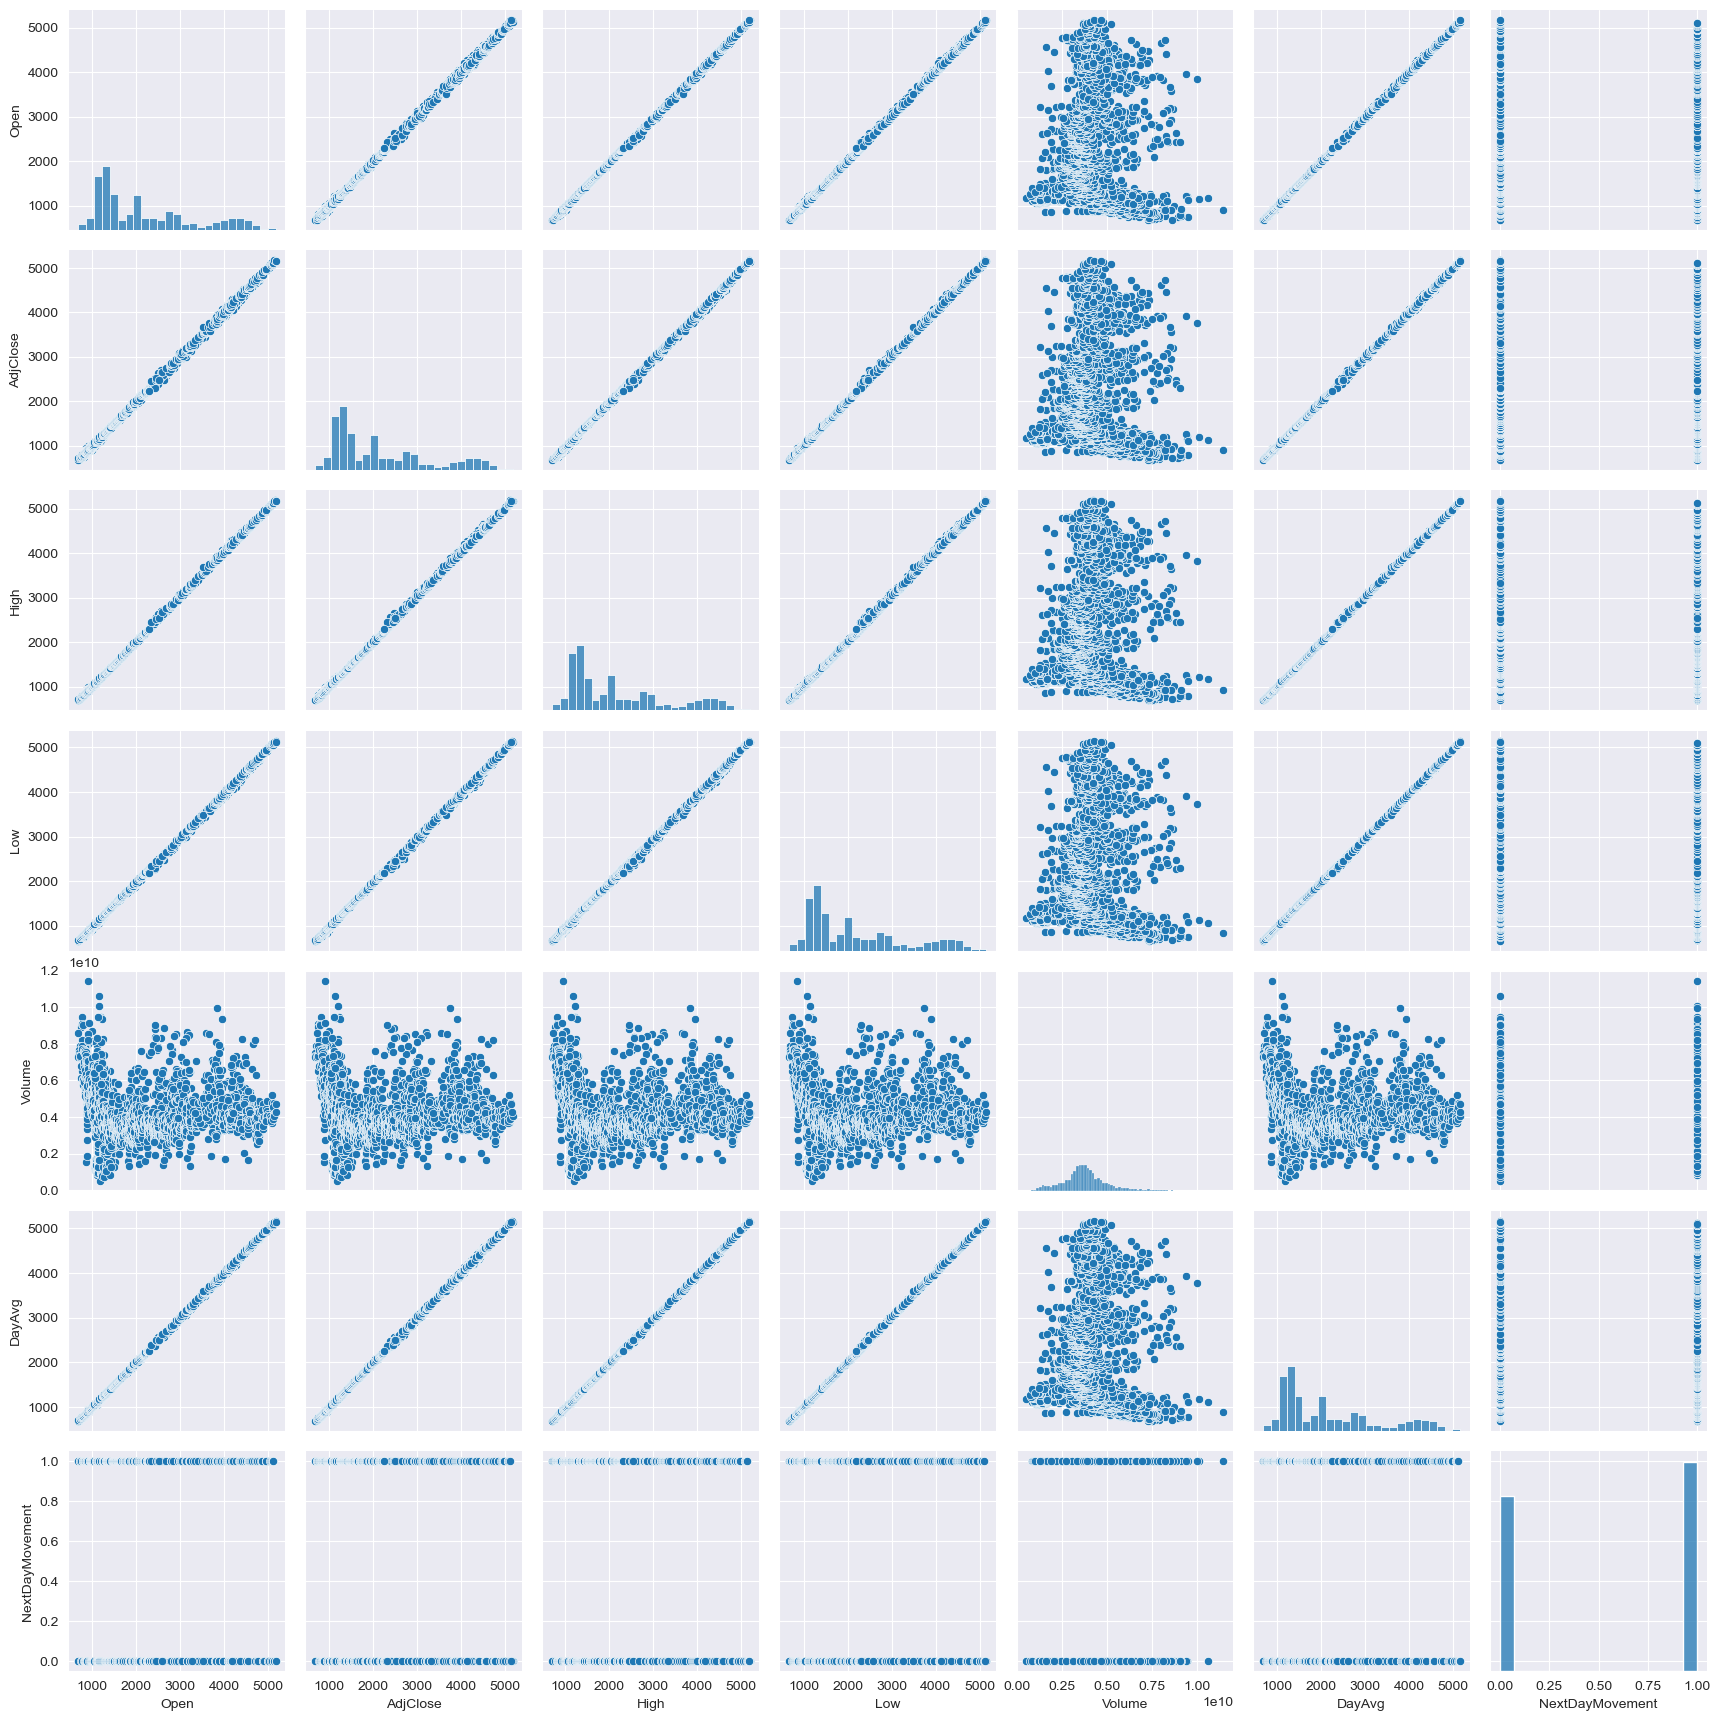

In [14]:
pairplot_vars = ['Open',  'AdjClose', 'High', 'Low', 'Volume', 'DayAvg', 'NextDayMovement']
sns.pairplot(SPX_historical, vars=pairplot_vars)

C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

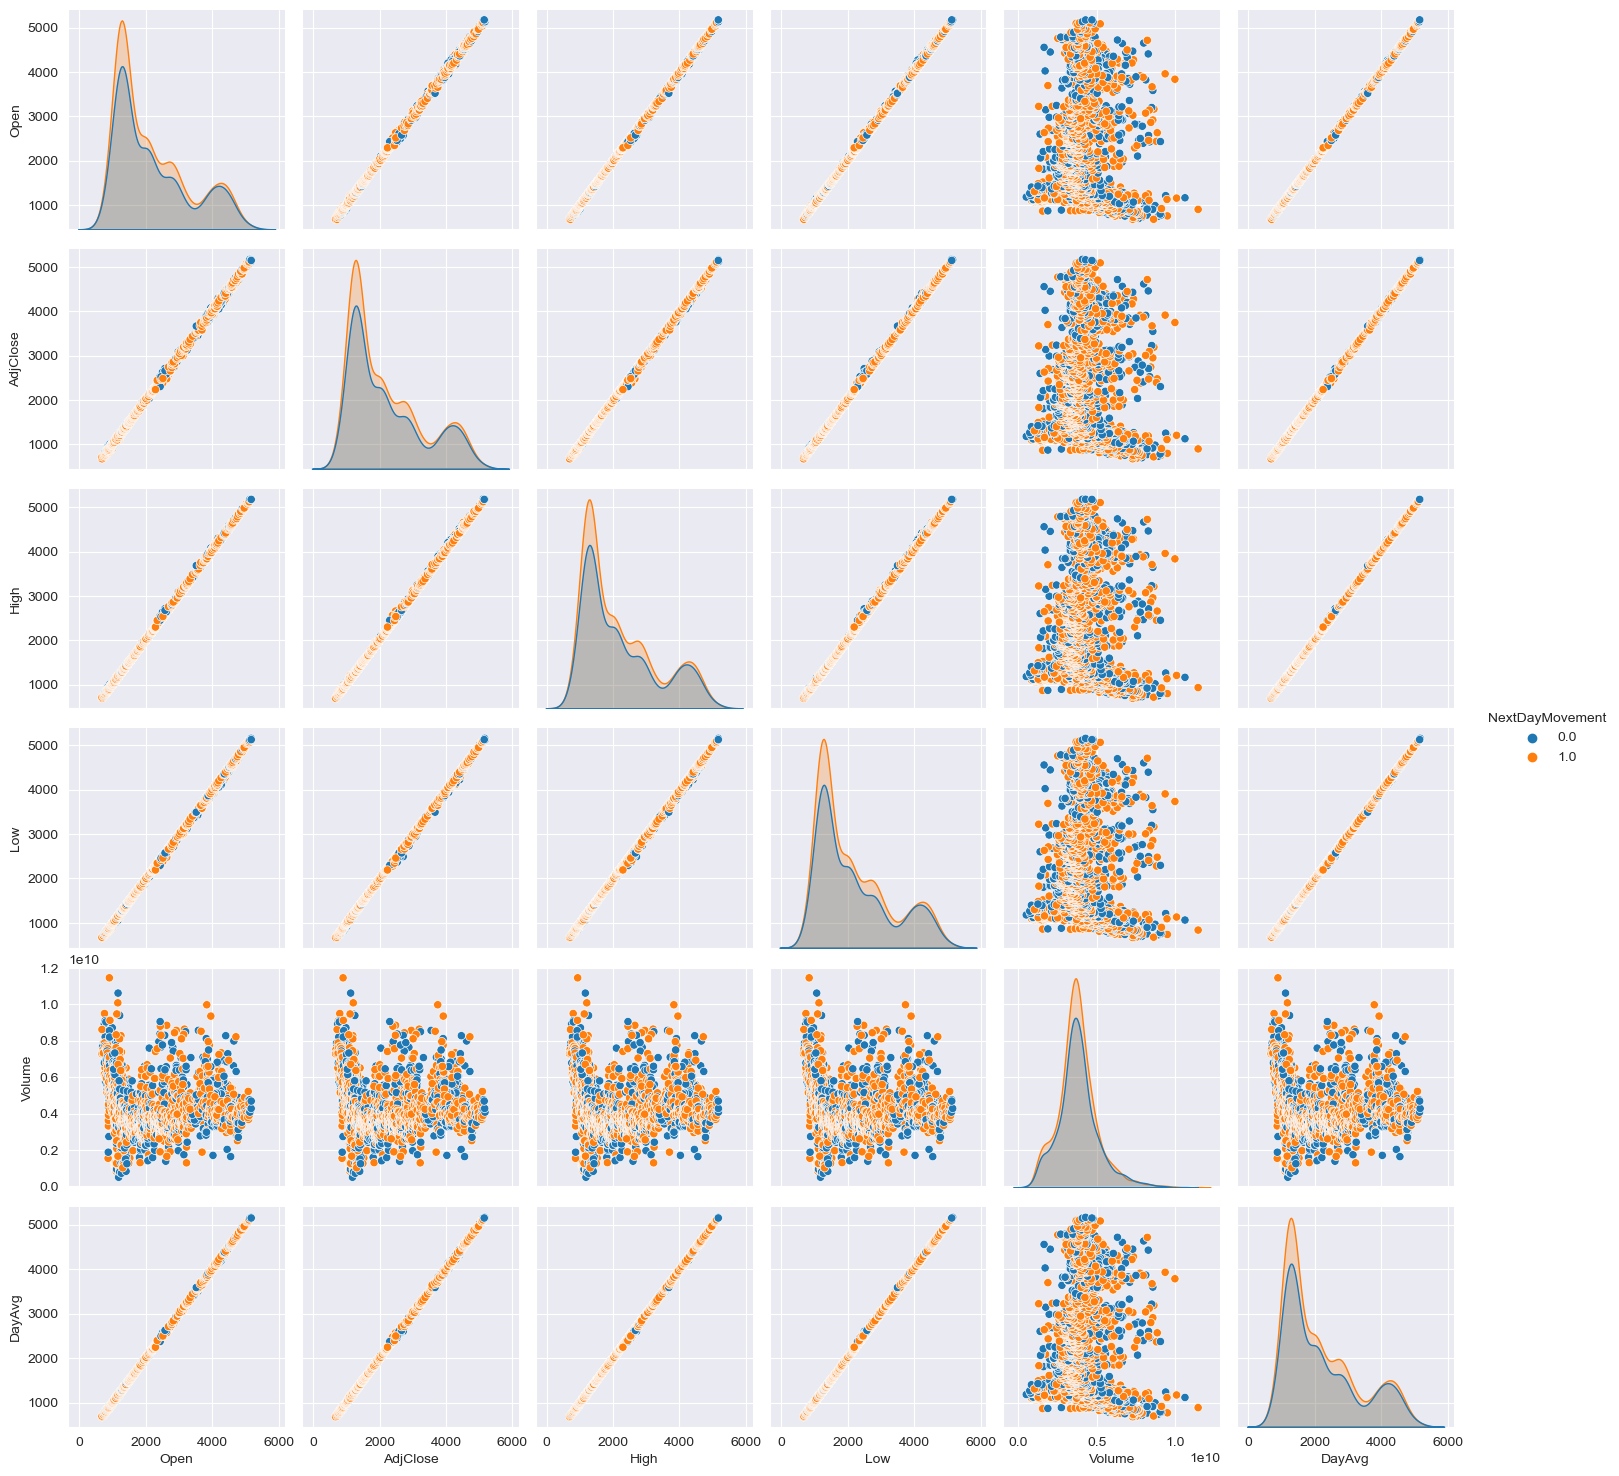

In [15]:
pairplot_vars = ['Open',  'AdjClose', 'High', 'Low', 'Volume', 'DayAvg']
sns.pairplot(SPX_historical, vars=pairplot_vars, hue='NextDayMovement')

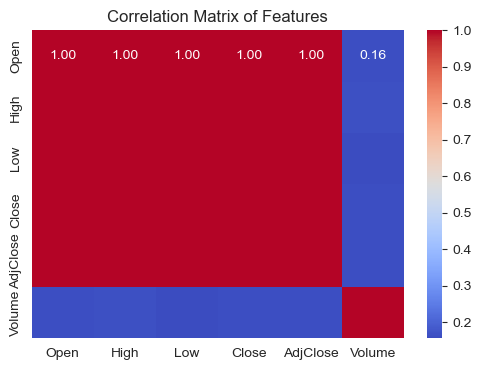

In [16]:
correlation_matrix = SPX_historical[['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

Both of these matrices and the corr matrix reveal that most of our features are extremely colinear. Only Volume appears to have a more dispersed distribution with relation to our other variables. 
Since Day Average is simply a function of other variables, I believe it has served its purpose for data exploration and I now opt to remove it for the purpose of model building.

In [17]:
SPX_historical.drop(["DayAvg", "DayAvgLag1", "DayAvgLag2", "DayAvgLag3", "DayAvgLag4", "DayAvgLag5", "DayAvgLag6", "DayAvgLag7"], axis=1, inplace=True)
SPX_historical.columns

Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'OpenLag1',
       'OpenLag2', 'OpenLag3', 'OpenLag4', 'OpenLag5', 'OpenLag6', 'OpenLag7',
       'HighLag1', 'HighLag2', 'HighLag3', 'HighLag4', 'HighLag5', 'HighLag6',
       'HighLag7', 'LowLag1', 'LowLag2', 'LowLag3', 'LowLag4', 'LowLag5',
       'LowLag6', 'LowLag7', 'CloseLag1', 'CloseLag2', 'CloseLag3',
       'CloseLag4', 'CloseLag5', 'CloseLag6', 'CloseLag7', 'AdjCloseLag1',
       'AdjCloseLag2', 'AdjCloseLag3', 'AdjCloseLag4', 'AdjCloseLag5',
       'AdjCloseLag6', 'AdjCloseLag7', 'VolumeLag1', 'VolumeLag2',
       'VolumeLag3', 'VolumeLag4', 'VolumeLag5', 'VolumeLag6', 'VolumeLag7',
       'NextDayMovement'],
      dtype='object')

We are predicting next-day performance on adjusted close, and I believe close may offer very little additional information over *adjusted* close, and will do little other than overweight both features. So, I opt to drop close and its lag terms as well. 

In [18]:
SPX_historical.drop(["Close", "CloseLag1", "CloseLag2", "CloseLag3", "CloseLag4", "CloseLag5", "CloseLag6", "CloseLag7"], axis=1, inplace=True)
SPX_historical.columns

Index(['Open', 'High', 'Low', 'AdjClose', 'Volume', 'OpenLag1', 'OpenLag2',
       'OpenLag3', 'OpenLag4', 'OpenLag5', 'OpenLag6', 'OpenLag7', 'HighLag1',
       'HighLag2', 'HighLag3', 'HighLag4', 'HighLag5', 'HighLag6', 'HighLag7',
       'LowLag1', 'LowLag2', 'LowLag3', 'LowLag4', 'LowLag5', 'LowLag6',
       'LowLag7', 'AdjCloseLag1', 'AdjCloseLag2', 'AdjCloseLag3',
       'AdjCloseLag4', 'AdjCloseLag5', 'AdjCloseLag6', 'AdjCloseLag7',
       'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'VolumeLag4', 'VolumeLag5',
       'VolumeLag6', 'VolumeLag7', 'NextDayMovement'],
      dtype='object')

# Changing Targets
From the above exploration, I suspect that it will be very difficult to predict next-day stock price movement direction. Instead, I decide to instead try *basis point movement magnitude* as a target. 

I first tried a threshold of 0.75 basis points, but that yields unbalanced class distribution. A value of 0.50 basis points, or 0.5%, yields a very balanced class distribution.

Here 1 indicates an adjusted close change of 0.5 basis points in either direction, or +/- 0.0050%. 

In [19]:
# Drop next day movement
SPX_historical.drop('NextDayMovement', axis=1, inplace=True)
# Add next day magnitude
SPX_historical['NextDayMagnitude'] = pd.Series(np.zeros(SPX_historical.shape[0]))
SPX_historical.loc[SPX_historical['AdjClose'].shift(-1)/SPX_historical["AdjClose"] > 1.005, 'NextDayMagnitude'] = 1
SPX_historical.loc[SPX_historical['AdjClose'].shift(-1)/SPX_historical["AdjClose"] < 0.995, 'NextDayMagnitude'] = 1
# Clip the last row since we don't have a valid target for NextDayMagnitude for our most recent day.
SPX_historical = SPX_historical.iloc[:4993].reset_index(drop=True)
SPX_historical.iloc[:,[0,3,40]]

,Open,AdjClose,NextDayMagnitude
0,1095.449951,1097.280029,0.0
1,1097.280029,1096.439941,0.0
2,1096.439941,1095.699951,1.0
3,1095.699951,1084.099976,1.0
4,1084.099976,1091.489990,0.0
...,...,...,...
4988,5132.379883,5157.359863,1.0
4989,5164.459961,5123.689941,0.0
4990,5111.959961,5117.939941,1.0
4991,5134.299805,5175.270020,0.0


C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

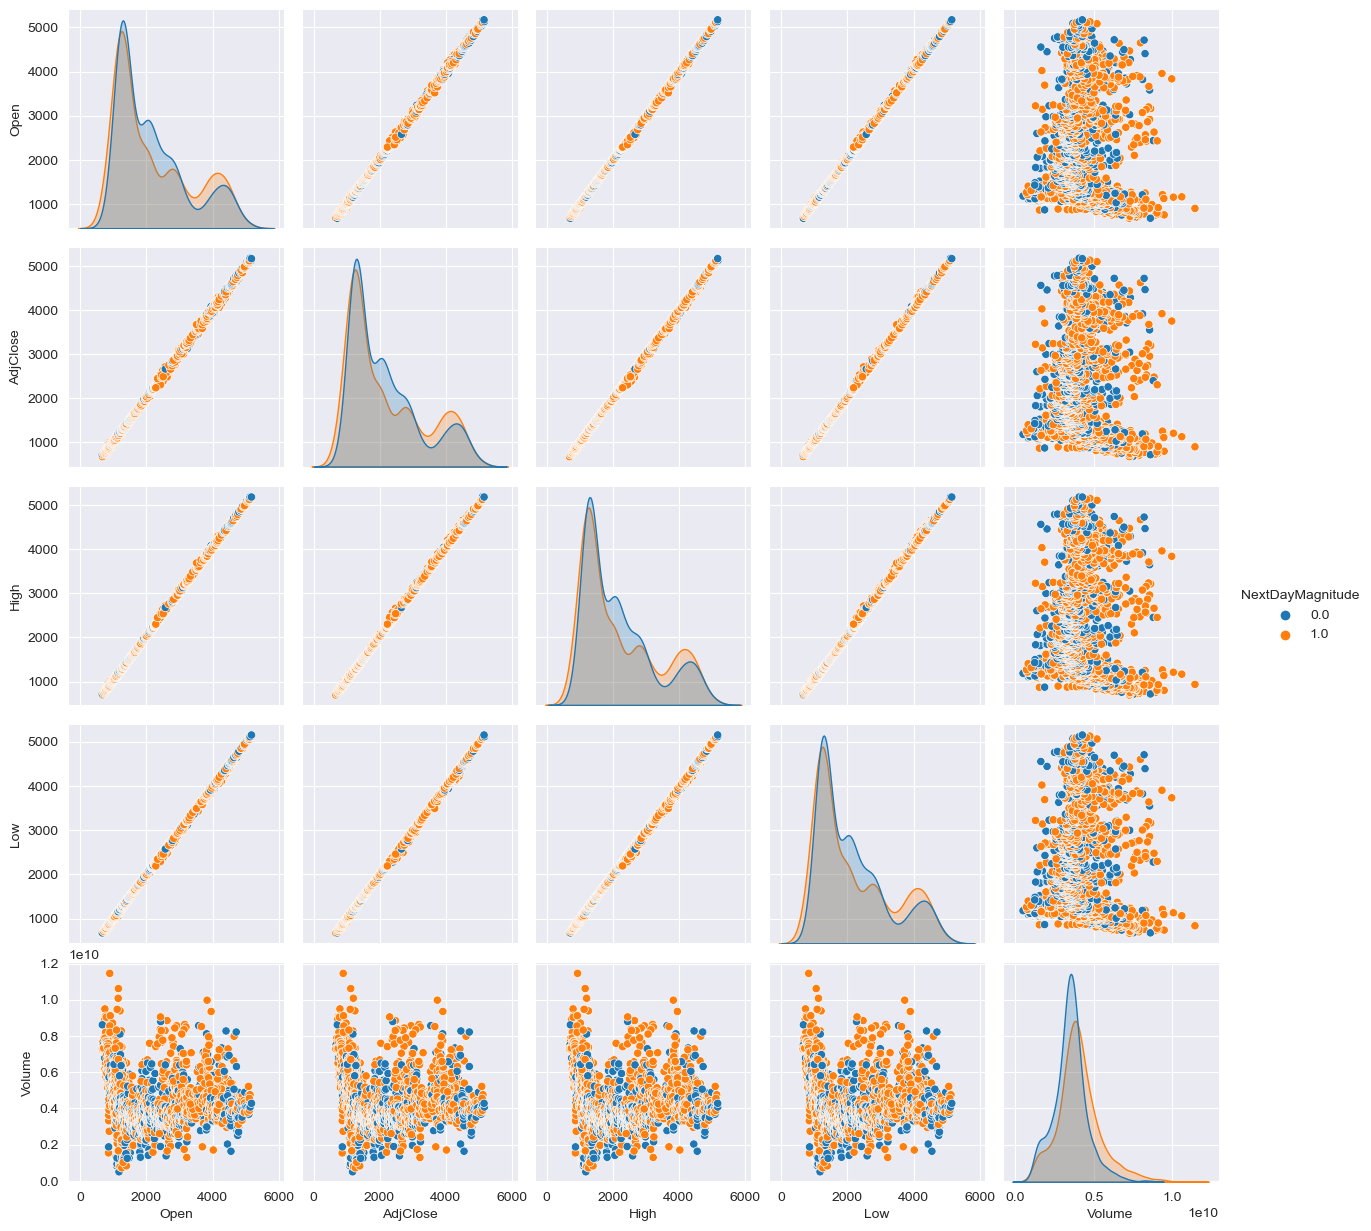

In [20]:
pairplot_vars = ['Open',  'AdjClose', 'High', 'Low', 'Volume']
sns.pairplot(SPX_historical, vars=pairplot_vars, hue='NextDayMagnitude')

There is still heavy colinearity between most variables. Note that there seems to be a slight difference in trade volume on high-magnitude change vs low-magnitude change days. It seems to make sense that days with large movements would also see a larger volume of trading.

# Splitting my X and Y data

In [21]:
X = SPX_historical.iloc[:, 0:40]
Y = SPX_historical.iloc[:, 40]

# Clustering

I experimented with clustering for the sake of experimentation, but as we can infer from the scatterplots above, there are no meaningful clusters in the feature distributions. I produce that code here only to demonstrate.

Text(0, 0.5, 'NextDayMagnitude')

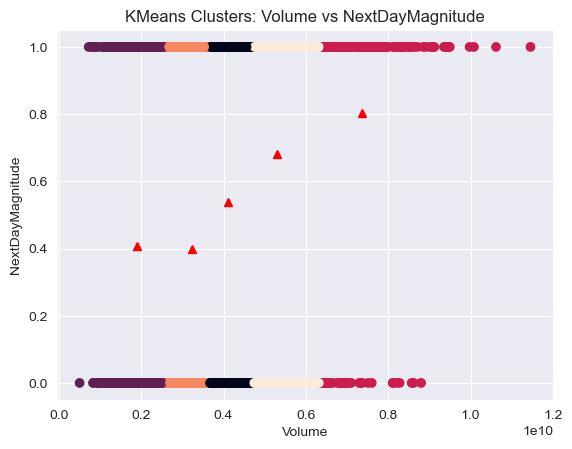

In [22]:
from sklearn.cluster import KMeans
model_km = KMeans(n_clusters=5, random_state=42)
model_km.fit(SPX_historical.iloc[:,[4,40]])
plt.plot(model_km.cluster_centers_[:, 0], model_km.cluster_centers_[:, 1], 'r^')
plt.scatter(SPX_historical.iloc[:, 4], SPX_historical.iloc[:, 40], c=model_km.predict(SPX_historical.iloc[:,[4,40]]))
plt.title('KMeans Clusters: Volume vs NextDayMagnitude')
plt.xlabel('Volume')
plt.ylabel('NextDayMagnitude')

As expected, the clusters appear to be mostly meaningless.

# Scaling data
Scaling will benefit our data in at least 2 ways:
1. Reducing the impact of outliers (although our data already apprears to be relatively tightly distributed).
2. Forcing trading index values and volume values to be in the same range, potentially improving the performance of linear models and neural network models.

In [23]:
scalar = StandardScaler()
scalar.fit(X)
X_scaled = scalar.transform(X)
X_scaled

array([[-0.97595404, -0.98002392, -0.98669251, ..., -1.80718701,
        -1.6552228 , -1.72511309],
       [-0.97431431, -0.97537097, -0.97278374, ..., -1.77564873,
        -1.80630464, -1.65432502],
       [-0.97506702, -0.97596823, -0.97595466, ..., -1.66272134,
        -1.77477384, -1.80536563],
       ...,
       [ 2.6227883 ,  2.60963912,  2.62995069, ...,  0.76708799,
         0.75927787,  1.12842017],
       [ 2.64280452,  2.65885186,  2.65097576, ...,  0.50098472,
         0.76736009,  0.7595166 ],
       [ 2.67791865,  2.65820118,  2.68466646, ...,  0.61104784,
         0.50131991,  0.76759661]])

# Dimensionality Reduction

I experiment with dimensionality reduction, just to explore the data and to test my suspicion that it may not be useful. I do not believe I will use reduced data for my final models for the following reasons:
1. This is a very difficult prediction task and I suspect that the signal-to-noise ratio will be low. I believe I cannot afford to train on data which only captures a percentage of the variance in the original data.
2. PCA may fail to capture non-linear trends in the data, which I suspect there may be.
3. If I want to autoencode with a NN (which *could* capture non-linearity), I will do so as layers in my final NN prediction model.
4. I expect dimensionality reduction to combine all of my highly colinear features into one feature that will explain most of the variance in the original, and that even the 2nd feature will explain much less. Although this *may* be beneficial, I'm still afraid of the performance impact of reducing the data.
5. I anticipate that my final optimal model will be a NN, which tend to perform relatively well on high-dimensional data, anyway.

On the other hand, it *may* still prove useful for constructing reduced data for testing with alternative ML prediction methods.

X shape: (4993, 40)
X_reduced shape: (4993, 5)


([<matplotlib.axis.XTick at 0x1d267a74ed0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

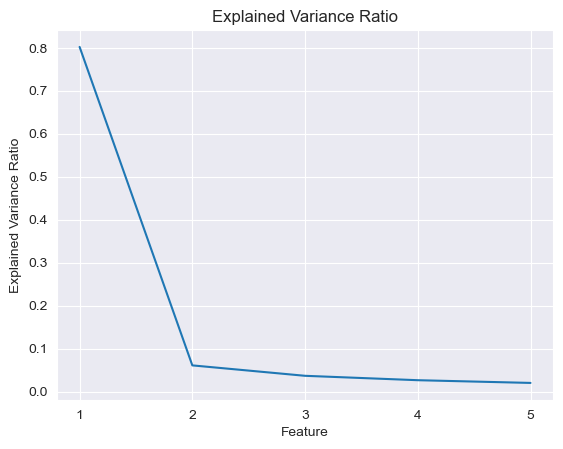

In [24]:
# Perform PCA
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X)
print('X shape:', X.shape)
print('X_reduced shape:', X_reduced.shape)
# Plot explained variance ratio
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Feature')
plt.xticks((0,1,2,3,4), (1,2,3,4,5))

As suspected, a single component accounts for nearly all the total variance that explained by the PCA model. I keep a 1-dim reduced X for later experimentation.

In [25]:
# Fit, Transform, & Inspect PCA
pca = PCA(n_components=1)
X_reduced = pca.fit_transform(X)
print('X_reduced shape:', X_reduced.shape)
print('Explained variance: ', pca.explained_variance_ratio_)

X_reduced shape: (4993, 1)
Explained variance:  [0.801839]


# Train-Test-Split
I perform a train-test-split on the data with a test size of 20%. I choose not to stratify, since my classes should already be balanced.
I also split all of my modified X_data for experimentation.

In [26]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(
    X,
    Y,
    test_size=0.2)

In [27]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = skl.model_selection.train_test_split(
    X_scaled,
    Y,
    test_size=0.2)

In [28]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = skl.model_selection.train_test_split(
    X_reduced,
    Y,
    test_size=0.2)

# Regression
 I start with a simple Logistic Regression model. 

In [29]:
# Baseline LogReg, these parameters were chosen by experimentation.
lrc = LogisticRegression(l1_ratio=0.5, 
                         penalty='elasticnet',
                         solver='saga',
                         max_iter=10000)

lrc.fit(X_train, y_train)
lrc_preds = lrc.predict(X_test)
lrc_probs = lrc.predict_proba(X_test)[:,1]

print("Model accuracy: ", skl.metrics.accuracy_score(y_test, lrc_preds))
print("Model F1: ", skl.metrics.f1_score(y_test, lrc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test, lrc_probs))

Model accuracy:  0.5015015015015015
Model F1:  0.6630581867388363
Model AUC:  0.5912607116804413


Our Logistic Regression model performs better than random guessing by some metrics, but this performance is not particularly good. Repeatedly running this model with different penalties does little to change performance.

In [30]:
# LogReg on dim-reduced data
lrc = LogisticRegression(l1_ratio=0.5,
                         penalty='elasticnet',
                         solver='saga',
                         max_iter=10000)

lrc.fit(X_train_reduced, y_train_reduced)
lrc_preds = lrc.predict(X_test_reduced)
lrc_probs = lrc.predict_proba(X_test_reduced)[:,1]

print("Model accuracy: ", skl.metrics.accuracy_score(y_test_reduced, lrc_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_reduced, lrc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_reduced, lrc_probs))

Model accuracy:  0.5815815815815816
Model F1:  0.5717213114754098
Model AUC:  0.6107545429018412


LogReg performs better, but still poorly on the dimensionally-reduced data. Rerunning this model with different penalties does little to change performance. I do not construct a model using the scaled data, as LogReg is not sensitive to feature scaling.

# KNN Model
Next, I experiment with KNN models. My suspicion is that it may perform better on the scaled data.

In [31]:
# Baseline KNN
knn = KNeighborsClassifier(n_neighbors=1000,
                           weights='distance')

knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_probs = knn.predict_proba(X_test)[:,1]

print("Model accuracy: ", skl.metrics.accuracy_score(y_test, knn_preds))
print("Model F1: ", skl.metrics.f1_score(y_test, knn_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test, knn_probs))

Model accuracy:  0.5775775775775776
Model F1:  0.491566265060241
Model AUC:  0.6309330084090199


KNN performs slightly better in terms of ROC AUC & accuracy and slightly worse in terms of F1 than our baseline LogReg model.

In [32]:
knn = KNeighborsClassifier(n_neighbors=100,
                           weights='distance')

knn.fit(X_train_reduced, y_train_reduced)
knn_preds = knn.predict(X_test_reduced)
knn_probs = knn.predict_proba(X_test_reduced)[:,1]

print("Model accuracy: ", skl.metrics.accuracy_score(y_test_reduced, knn_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_reduced, knn_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_reduced, knn_probs))

Model accuracy:  0.5625625625625625
Model F1:  0.5703048180924287
Model AUC:  0.588322836856673


KNN does not perform well on the dimensionally-reduced data. The failure of both LogReg & KNN so far to perform better on the dimensionally-reduced data seems to affirm my suspicion that dimensionality reduction loses too much of the variance from a dataset that likely already has a low signal-to-noise ratio.

In [48]:
knn = KNeighborsClassifier(n_neighbors=100,
                           weights='distance')

knn.fit(X_train_scaled, y_train_scaled)
knn_preds = knn.predict(X_test_scaled)
knn_probs = knn.predict_proba(X_test_scaled)[:,1]

print("Model accuracy: ", skl.metrics.accuracy_score(y_test_scaled, knn_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_scaled, knn_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_scaled, knn_probs))

Model accuracy:  0.5665665665665666
Model F1:  0.5298588490770901
Model AUC:  0.6147013523212024


Surprisingly, KNN barely benefits from scaled data, compared to our baseline model. This may have to do with the scaling method. It might be possible that scaling the data without mean or without stdv *might* scale in a way that benefits performance more. However, this is very speculative, and I opt to continue using the scaled data as-is.

Now, I optimize this model.

In [142]:
start = datetime.datetime.now()
parameters = {'n_neighbors': [2,5,10,100,1000], 
              'weights': ['distance', 'uniform'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 50, 100]}
knn = KNeighborsClassifier()
gs_knn = skl.model_selection.GridSearchCV(knn,
                                          parameters,
                                          scoring = "roc_auc",
                                          n_jobs = -1,
                                          verbose = 3)

gs_knn.fit(X_train_scaled, y_train_scaled)
end = datetime.datetime.now()
time_elapsed = end - start
print("Time elapsed: ", time_elapsed)
print("Best score:", gs_knn.best_score_)
gs_knn.best_estimator_

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Time elapsed:  0:00:09.391907
Best score: 0.6472954056877189


KNeighborsClassifier(leaf_size=10, n_neighbors=100, weights='distance')

In [153]:
knn_opt = KNeighborsClassifier(leaf_size=10,
                               n_neighbors=100,
                               weights='distance')

knn_opt.fit(X_train_scaled, y_train_scaled)
knn_preds = knn_opt.predict(X_test_scaled)
knn_probs = knn_opt.predict_proba(X_test_scaled)[:,1]

print("Optimized KNN accuracy: ", skl.metrics.accuracy_score(y_test_scaled, knn_preds))
print("Optimized KNN F1: ", skl.metrics.f1_score(y_test_scaled, knn_preds))
print("Optimized KNN AUC: ", skl.metrics.roc_auc_score(y_test_scaled, knn_probs))

Optimized KNN accuracy:  0.5665665665665666
Optimized KNN F1:  0.5298588490770901
Optimized KNN AUC:  0.6147013523212024


Our KNN model can achieve an AUC of between 0.61 and 0.65. Experimentation (omitted here for brevity) reveals that our exact choice of n_neighbors trades off performance between F1 (lower n_neighbors yield F1 up to about 0.6) and AUC (lower n_neighbors yield AUC down to  about 0.61).

# SVM Classifier Model
I begin with a simple SVC on our unscaled data.

In [36]:
svc = skl.svm.SVC(probability = True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
svc_probs = svc.predict_proba(X_test)[:,1]
print("Model accuracy: ", skl.metrics.accuracy_score(y_test, svc_preds))
print("Model F1: ", skl.metrics.f1_score(y_test, svc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test, svc_probs))

Model accuracy:  0.5915915915915916
Model F1:  0.47959183673469385
Model AUC:  0.6338348818007647


Our baseline SVC performs almost as well as our optimal KNN, so I opt to investigate further. I continue by testing on the *scaled* data.

In [37]:
svc = skl.svm.SVC(probability = True)
svc.fit(X_train_scaled, y_train_scaled)
svc_preds = svc.predict(X_test_scaled)
svc_probs = svc.predict_proba(X_test_scaled)[:,1]
print("Model accuracy: ", skl.metrics.accuracy_score(y_test_scaled, svc_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_scaled, svc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_scaled, svc_probs))

Model accuracy:  0.5945945945945946
Model F1:  0.5732349841938883
Model AUC:  0.6384516446386955


Scaling the data results in our strongest model so far in terms of AUC.

Next, I test on the *reduced* data.

In [38]:
svc = skl.svm.SVC(probability = True)
svc.fit(X_train_reduced, y_train_reduced)
svc_preds = svc.predict(X_test_reduced)
svc_probs = svc.predict_proba(X_test_reduced)[:,1]
print("Model accuracy: ", skl.metrics.accuracy_score(y_test_reduced, svc_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_reduced, svc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_reduced, svc_probs))

Model accuracy:  0.5905905905905906
Model F1:  0.5336374002280502
Model AUC:  0.6034838942596976


SVC performs surprisingly well on the scaled data in terms of AUC, but at a loss to F1. This may be worth it for the performance increase, given the computational intensity of SVMs. However, I am aiming to produce the strongest model I can, regardless of execution time, so I opt to not move forward with this model.

I now optimize my SVM classifier model with Randomized Search.

In [39]:
# WILL TAKE VERY LONG TO RUN
# start = datetime.datetime.now()
# parameters = {'C': [0.1, 1],
#               'degree': [1, 2, 3],
#               'gamma': ['scale', 0.1, 1, 5, 10],
#               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],}
# svc = skl.svm.SVC()
# rs_svc = skl.model_selection.RandomizedSearchCV(svc,
#                                                 parameters,
#                                                 scoring = "roc_auc",
#                                                 n_jobs = -1,
#                                                 verbose = 3,
#                                                 n_iter = 10)
# rs_svc.fit(X_train, y_train)
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
# rs_svc.best_estimator_

SVM optimization takes excessively long to run, so much so that even *random search* is not able to explore many hyperparameter combinations in a reasonable amount of time, and the performance of the optimal model varies quite a bit, barely ever exceeding the performance of our baseline model. So, I spent some time manually testing different hyperparameter values and settled on the following optimal model.

In [147]:
svc_opt = skl.svm.SVC(kernel = 'linear',
                  C = 20,
                  probability = True)
svc_opt.fit(X_train_scaled, y_train_scaled)
svc_preds = svc_opt.predict(X_test_scaled)
svc_probs = svc_opt.predict_proba(X_test_scaled)[:,1]
print("Model accuracy: ", skl.metrics.accuracy_score(y_test_scaled, svc_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_scaled, svc_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_scaled, svc_probs))

Model accuracy:  0.6186186186186187
Model F1:  0.5458879618593564
Model AUC:  0.6866759670669065


This is our strongest model so far, with an AUC of nearly 0.69.

# XGBoost Model
For a tree-based model, I opt for XGBoost.

In [83]:
bst = XGBClassifier(booster = 'gbtree',
                    n_estimators=10,
                    max_depth=100,
                    objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
bst_preds = bst.predict(X_test)
bst_probs = bst.predict_proba(X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(y_test, bst_preds))
print("LRM F1: ", skl.metrics.f1_score(y_test, bst_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(y_test, bst_probs))

LRM Accuracy:  0.5905905905905906
LRM F1:  0.5889447236180905
LRM AUC:  0.6031848461285643


The XGBoost model does not seem to perform better than our other models so far. 

I take this opportunity to inspect feature importances.

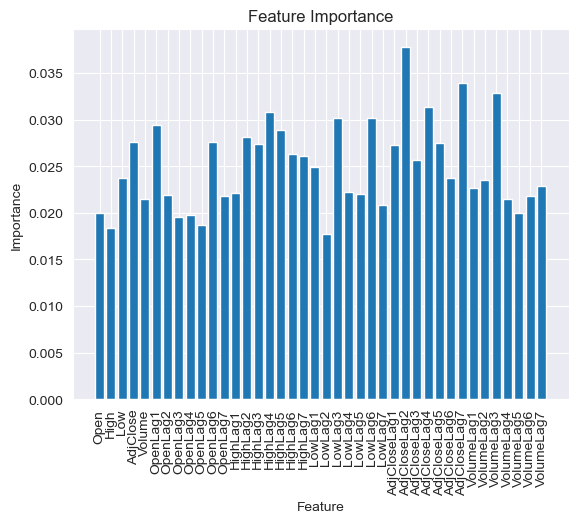

In [81]:
plt.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(np.arange(0,40), 
           list(X.columns), 
           rotation=90)
plt.show()

Importance seems to be relatively distributed, though some features are notably more significant, particularly **Adjusted Close Lag 2**.

Next, I'll try with the dimensionally-reduced data. 

In [90]:
bst = XGBClassifier(booster = 'gbtree',
                    n_estimators=2,
                    max_depth=100,
                    objective='binary:logistic')
# fit model
bst.fit(X_train_reduced, y_train_reduced)
# make predictions
bst.fit(X_train_reduced, y_train_reduced)
bst_preds=bst.predict(X_test_reduced)
bst_probs = bst.predict_proba(X_test_reduced)[:,1]
print("Model Accuracy: ", skl.metrics.accuracy_score(y_test_reduced, bst_preds))
print("Model F1: ", skl.metrics.f1_score(y_test_reduced, bst_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test_reduced, bst_probs))

Model Accuracy:  0.5785785785785785
Model F1:  0.5497326203208556
Model AUC:  0.607021942316178


Training our XGBoost model on the dimensionally-reduced data doesn't reduce AUC, but degrades performance significantly in terms of Accuracy & F1. 

I do not also experiment on this model with the scaled data, since tree-based models (like XGBoost) are not sensitive to feature scaling. Experimentation (omitted here for brevity) with XGBoost & scaled data revealed that scaling actually degrades performance slightly.

Next, I optimize my XGBoost model with Optuna.

In [91]:
# https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    roc_auc = skl.metrics.roc_auc_score(y_test, pred_labels)
    return roc_auc

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-05-20 12:58:20,020] A new study created in memory with name: no-name-80986cc4-19ed-4666-ae03-59cde47c4dca
[I 2024-05-20 12:58:20,044] Trial 0 finished with value: 0.5 and parameters: {'booster': 'gblinear', 'lambda': 2.5081576331253705e-06, 'alpha': 9.109001465199535e-05, 'subsample': 0.22870835463868114, 'colsample_bytree': 0.5309633241790597}. Best is trial 0 with value: 0.5.
[I 2024-05-20 12:58:20,096] Trial 1 finished with value: 0.6106058662733372 and parameters: {'booster': 'dart', 'lambda': 0.012645403223020492, 'alpha': 1.0015177883852222e-05, 'subsample': 0.8190078577080884, 'colsample_bytree': 0.5579745259340871, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.0016605760244719897, 'gamma': 0.0018585251808970174, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.224223178388346e-07, 'skip_drop': 0.01156894495029593}. Best is trial 1 with value: 0.6106058662733372.
[I 2024-05-20 12:58:20,117] Trial 2 finished with value: 0.

Number of finished trials:  1000
Best trial:
  Value: 0.6377688441405405
  Params: 
    booster: dart
    lambda: 8.953846464532092e-06
    alpha: 1.2782436364695654e-08
    subsample: 0.8588433254452426
    colsample_bytree: 0.4830451075646703
    max_depth: 7
    min_child_weight: 9
    eta: 0.003106264330176052
    gamma: 5.123869841427681e-06
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: forest
    rate_drop: 0.09299564671374859
    skip_drop: 0.07793232576789097


In [155]:
bst_opt = XGBClassifier(booster = 'dart',
                        reg_lambda = 8.953846464532092e-6,
                        alpha = 1.2782436364695654e-8,
                        subsample = 0.8588433254452426,
                        colsample_bytree = 0.4830451075646703,
                        max_depth = 7,
                        min_child_weight = 9,
                        eta = 0.003106264330176052,
                        gamma = 5.123869841427681e-06,
                        grow_policy = "lossguide",
                        sample_type = "uniform",
                        normalize_type = "forest",
                        rate_drop = 0.09299564671374859,
                        skip_drop = 0.07793232576789097,
                        objective = "binary:logistic")
# fit model
bst.fit(X_train, y_train)
# make predictions
bst.fit(X_train, y_train)
bst_preds=bst.predict(X_test)
bst_probs = bst.predict_proba(X_test)[:,1]
print("Model Accuracy: ", skl.metrics.accuracy_score(y_test, bst_preds))
print("Model F1: ", skl.metrics.f1_score(y_test, bst_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test, bst_probs))

Model Accuracy:  0.5635635635635635
Model F1:  0.5708661417322834
Model AUC:  0.601956359671976


Our optimized XGBoost model, trained on the reduced data achieves an AUC of between 0.6 and 0.64 across multiple trials. This performance does not exceed that of the best models tested so far.

# NN Model

In [92]:
model = keras.Sequential()
# Add convolutional layers to help detect non-linear trends in the data
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(40, 1)))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
# Batch normalization to stabilize & improve training
model.add(keras.layers.BatchNormalization())
# Flatten output from convolution
model.add(keras.layers.Flatten())
# Dropout layer to mitigate overfitting
model.add(keras.layers.Dropout(0.25))
# Add a dense layer for classification
model.add(keras.layers.Dense(64, activation='relu'))
# Binary classification output layer
model.add(keras.layers.Dense(1, activation='sigmoid'))  # Binary classification, so sigmoid activation
# Specify a solver with low learning rate to improve final model performance
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# Compile
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=optimizer,
              metrics=["AUC"])
# Inspect model
model.summary()

C:\Users\rmcne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 38, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 36, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,177 (602.25 KB)

 Trainable params: 154,049 (601.75 KB)

 Non-trainable params: 128 (512.00 B)

In [116]:
# Fit & score
model.fit(X_train, y_train)
model_probs = model.predict(X_test)
model_preds = tf.greater(model_probs, 0.5)
print("Model Accuracy: ", skl.metrics.accuracy_score(y_test, model_preds))
print("Model F1: ", skl.metrics.f1_score(y_test, model_preds))
print("Model AUC: ", skl.metrics.roc_auc_score(y_test, model_probs))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5682 - loss: 0.7009
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
Model Accuracy:  0.5195195195195195
Model F1:  0.6586059743954481
Model AUC:  0.6337948006765692


Despite my earlier suspicions that a NN would be the best-performing model type, our NN model does not significantly outperform our optimized XGBoost model and does not outperform our best model so far.

# Model Stacking
To experiement with model stacking, I choose my first and second-best performing models: SVC & KNN. While the KNN does not *especially* outperform all other models, I choose to use it because it is a model type that performs well on the scaled data. As mentioned above, using the scaled data with model types that are not sensitive to feature scaling actually degrades performance in some places.

In [160]:
# Optimized SVM classifier: svc_opt
# Optimal KNN: knn_opt

Model_1 = svc_opt
Model_2 = knn_opt
final_estimator = LogisticRegression(solver = 'saga',
                                     penalty = 'l1')

stackCL = skl.ensemble.StackingClassifier([('Model_1', Model_1),
                                           ('Model_2', Model_2)],
                                          final_estimator = final_estimator)

stackCL.fit(X_train_scaled, y_train_scaled)
stack_preds = stackCL.predict(X_test_scaled)
stack_probs = stackCL.predict_proba(X_test_scaled)[:,1]

print("Stacking Model Accuracy: ", skl.metrics.accuracy_score(y_test_scaled, stack_preds))
print("Stacking Model F1: ", skl.metrics.f1_score(y_test_scaled, stack_preds))
print("Stacking Model AUC: ", skl.metrics.roc_auc_score(y_test_scaled, stack_probs))

Stacking Model Accuracy:  0.6336336336336337
Stacking Model F1:  0.6089743589743589
Stacking Model AUC:  0.6829867187059004


Model stacking does not improve performance over our singular best model performance. So, I take the optimized SVM model is my best model.

# Cross-validation of final model
I validate performance (in terms of AUC) of our best model via 5-fold cross validation. 

In [182]:
# 5-fold cross-validation
auc_scores = cross_val_score(svc_opt, X_scaled, Y, cv=5, scoring='roc_auc')
print("Mean cross-validation AUC: ", np.mean(auc_scores))
print("Standard deviation of cross-validation AUC:", np.std(auc_scores))

Mean cross-validation AUC:  0.716042014953602
Standard deviation of cross-validation AUC: 0.031307474718114695


Cross-validated ROC AUC reaches nearly 0.72, with a standard deviation of only about 0.03 (implying consistent performance across folds). 

I plot an ROC curve to further inspect performance.

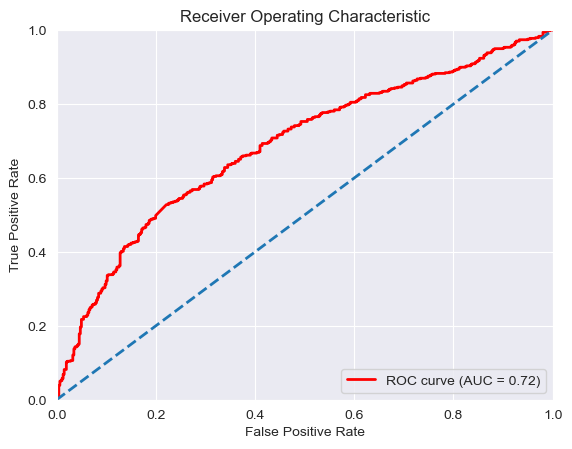

In [183]:
svc_opt_probs = svc_opt.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_scaled, svc_opt_probs)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % np.mean(auc_scores))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

We have a relatively even curve. Given that we are classifying *size* of next-day movement and not direction, both false positives and false negatives could be equally dangerous, depending on how one is trading. So, I opt to keep our classification probability threshold at exactly 0.5.